In [23]:
#import kazane
#import pydub
import wave
import scipy as sp
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import IPython.display
import os
from scipy.io.wavfile import write
import time
import torch
from torch.nn import functional as F
import glob
import tqdm
import transformers

## 必要な関数の定義

In [2]:
def LSD(x, y):
    return (1/x.shape[0])*(((1/x.shape[1])*((x-y)**2).sum(axis=1)) ** 0.5).sum()

In [12]:
from torch.nn import functional as F

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def downsampling(waveform, dr):
    down_waveform = signal.resample(waveform, len(waveform)//dr, t=None, axis=0, window=None, domain='time')
    down_waveform = np.array(down_waveform, dtype=np.int16) # 戻しておかないとすごい音がする
    return  down_waveform  

def sinc(waveform, ur):
    waveform = torch.tensor((waveform/ 32768).tolist()) 
    waveform.to(device)
    upsampler = kazane.Upsample(ur)
    waveform_bi = upsampler(waveform)
    waveform_bi = waveform_bi * 32768
    x_numpy = waveform_bi.to('cpu').detach().numpy()
    x_numpy = x_numpy.astype(np.int16)
    #waveform_bicubic = torch.from_numpy(x_numpy)
    waveform_bicubic = x_numpy
    
    return waveform_bicubic

def bicubic(waveform):
    waveform = torch.tensor([[[(waveform / 32768)]]]) 
    waveform.to(device)
    waveform_bi = F.interpolate(waveform, (1,  2 * len(waveform[0][0][0])), mode='bicubic', align_corners=False)
    waveform_bi = (waveform_bi * 32768).to(torch.int16)
    x_numpy = waveform_bi.to('cpu').detach().numpy().reshape(-1)
    return x_numpy

# まとめてGPUでbicubic補完：あまり速くならない
def batch_bicubic(waveforms):
    waveforms = torch.tensor((waveforms / 32768).reshape((len(waveforms), 1, 1, -1)))
    waveforms.to(device)
    waveforms_bi = F.interpolate(waveforms, (1,  2 * len(waveforms[0][0][0])), mode='bicubic', align_corners=False)
    waveforms_bi = (waveforms_bi * 32768).to(torch.int16)
    x_numpy = waveforms_bi.to('cpu').detach().numpy().reshape((len(waveforms), -1))
    return x_numpy
    
# scipy を使った方法．速さは pytorch と同じくらい．
from scipy.interpolate import interp1d
def scipy_bicubic(waveform):
    xs = np.linspace(1, len(waveform), len(waveform))
    xs2 = np.linspace(1, len(waveform), 2 * len(waveform))
    f = interp1d(xs, waveform / 32768, kind='cubic')
    waveform_bi = f(xs2) * 32768
    return waveform_bi.astype(np.int16)

In [4]:
def get_spectral(angle_a, abs_a):
    return abs_a * (np.cos(angle_a) + 1j * np.sin(angle_a))

In [5]:
def pred_show_spe(fname):
    netG.eval()
    amp = 2 * np.sqrt(2)
    pred_spectral=[]
    nover = 192
    with wave.open(fname) as wave_file:
        length = wave_file.getnframes()
        fs = wave_file.getframerate()
        x = wave_file.readframes(wave_file.getnframes())
        wav_x = np.frombuffer(x, dtype= "int16")
        #wav_x = bicubic(wav_x)#16000Hz
        f, t, Zxx = signal.stft(wav_x[:length], fs, nperseg=256, noverlap=nover)
        data = np.log(np.abs(Zxx) +10**(-10)).T
        angle_data = np.angle(Zxx).T
    i = 0
    #in_rate = ((129-79)/129)
    pred_sp = []
    input_sp = torch.tensor(data)[i:i+time_size]
    input_sp = input_sp.unsqueeze(0)
    output_sp = netG(input_sp.to(device))
    input_sp = input_sp.squeeze().tolist()
    output_sp = output_sp.squeeze().tolist()
    for j in range(time_size//4):
        sp = output_sp[j]
        pred_sp.append(sp)
    while i <= len(data)-time_size:
        input_sp = torch.tensor(data)[i:i+time_size]
        input_sp = input_sp.unsqueeze(0)
        output_sp = netG(input_sp.to(device))
        input_sp = input_sp.squeeze().tolist()
        output_sp = output_sp.squeeze().tolist()
        for j in range(time_size//2):
            sp = output_sp[j+time_size//4]
            pred_sp.append(sp)
        i += time_size//2
    #最後
    for j in range(time_size//4):
        sp = output_sp[j + 3 * time_size//4]
        pred_sp.append(sp)

    input_sp = torch.tensor(data)[-time_size:]
    input_sp = input_sp.unsqueeze(0)
    output_sp = netG(input_sp.to(device))
    input_sp = input_sp.squeeze().tolist()
    output_sp = output_sp.squeeze().tolist()
    for i in range(len(data)%(time_size//2)):
        sp = output_sp[time_size - len(data)%(time_size//2) + i]
        pred_sp.append(sp)
    num_pred = np.array(pred_sp)
    magnitude_spectrogram = np.exp(num_pred.T) 
    spectral_dnn= get_spectral(angle[number], magnitude_spectrogram)
    spectral_dnn = np.where(np.abs(spectral_dnn) >= amp/10, spectral_dnn, 0)
    _, wav_xrec = signal.istft(spectral_dnn, fs, nperseg=256, noverlap=nover)
    wav_xrec = np.array(wav_xrec, dtype=np.int16) # 戻しておかないとすごい音がする
    plt.pcolormesh(t, f, np.log(magnitude_spectrogram), vmin=0, vmax=amp)
    plt.colorbar()
    #plt.title('8000 to 16000')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

In [6]:
def pred_spec_2d(time_size, data_num, net, magnitude, angle, wav_m, wav_name):
    #出力の真ん中部分の採用
    net.eval()
    pred_spectral=[]
    pred_sp = []
    amp = 2 * np.sqrt(2)
    #time_size = 32
    sp_size = 129
    lengths = min(len(wav_m[data_num]), len(magnitude[data_num]))
    #print(lengths)
    data = magnitude[data_num][:lengths]
    nover = 192
    sp_0 = [1e-3] * sp_size
    
    i = 0
    input_sp = torch.tensor(data)[i:i+time_size]
    input_sp = input_sp.unsqueeze(0)
    output_sp = net(input_sp.to(device))
    output_sp = output_sp.squeeze().tolist()
    #最初のdata:32*129のうち前半 1/4部分
    for j in range(time_size//4):
        if j == 0:
            pred_sp.append(sp_0)
        else:
            sp = output_sp[j]
            pred_sp.append(sp)

    #中間のdeta:32*129のうち真ん中　2/4部分
    while i <= len(data)-time_size:
        input_sp = torch.tensor(data)[i:i+time_size]
        input_sp = input_sp.unsqueeze(0)
        output_sp = net(input_sp.to(device))
        output_sp = output_sp.squeeze().tolist()
        for j in range(time_size//2):
            sp = output_sp[j + time_size//4]
            pred_sp.append(sp)
        i += time_size//2

    #最後のdata:32*129のうち後半 1/4部分
    for j in range(time_size//4):
        sp = output_sp[j + 3 * time_size//4]
        pred_sp.append(sp)

    input_sp = torch.tensor(data)[-time_size:]
    input_sp = input_sp.unsqueeze(0)
    output_sp = net(input_sp.to(device))
    output_sp = output_sp.squeeze().tolist()
    for i in range(len(data)%(time_size//2)):
        sp = output_sp[time_size - len(data)%(time_size//2) + i]
        pred_sp.append(sp)

    num_pred = np.array(pred_sp)
    magnitude_spectrogram = np.exp(num_pred.T) 
    # num_pred = np.exp(np.array(pred_sp))
    # print(num_pred[:5])
    # magnitude_spectrogram = num_pred.T
    
    #LSDの計算
#     input_up = magnitude[data_num][:lengths, sp_size//2:]
#     input_down = magnitude[data_num][:lengths, :sp_size//2]
    
#     lsd_in_label_up = LSD(input_up, wav_m[data_num][:lengths, sp_size//2:])
#     lsd_in_label_down = LSD(input_down, wav_m[data_num][:lengths, :sp_size//2])
#     lsd_out_label_up = LSD(num_pred[:lengths, sp_size//2:], wav_m[data_num][:lengths, sp_size//2:])
#     lsd_out_label_down = LSD(num_pred[:lengths, :sp_size//2], wav_m[data_num][:lengths, :sp_size//2])
    lsd_pre = LSD(num_pred[:lengths], wav_m[data_num][:lengths])
    
    spectral_cnn_2d = get_spectral(angle[data_num][:, :lengths], magnitude_spectrogram)
    spectral_cnn_2d = np.where(np.abs(spectral_cnn_2d) >= amp/10, spectral_cnn_2d, 0)
    _, wav_xrec_2d = signal.istft(spectral_cnn_2d, 8000, nperseg=256, noverlap=nover)
    wav_xrec_2d = np.array(wav_xrec_2d, dtype=np.int16) # 戻しておかないとすごい音がする
    
    _, _, Zxx = signal.stft(wav_xrec_2d, 8000, nperseg = 256, noverlap = nover)
    
    lsd = LSD(np.log(np.abs(Zxx.T)[:length] + 10**(-10)), wav_m[data_num][:lengths])

    #print('LSD_in_label_up : {0}, LSD_out_label_up : {1}'.format(lsd_in_label_up, lsd_out_label_up))
    #print('LSD_in_label_down : {0}, LSD_out_label_down : {1}'.format(lsd_in_label_down, lsd_out_label_down))
    
    # write(wav_name, 8000, wav_xrec_2d)
    # return IPython.display.Audio(wav_name)
    return lsd_pre, lsd

## 前処理(音声波形を周波数領域に変換, フレームサイズ : 256, フレームシフト : 64)

In [11]:
#p = '/home/corpus/VCTK-Corpus/wav48/'

wav_file_LF = sorted(glob.glob('celp/*.wav'))[:10]
LF_magnitude = []
angle = []
data_size = len(wav_file_LF)
i = 0
nover = 192

for i, wav in tqdm.tqdm(enumerate(wav_file_LF)):
    wave_file = wave.open(wav, 'r')
    length = wave_file.getnframes()
    x = wave_file.readframes(wave_file.getnframes())
    wav_x_16000 = np.frombuffer(x, dtype= "int16")
    f_16000, t_16000, Zxx_16000 = signal.stft(wav_x_16000[:length], 8000, nperseg = 256, noverlap = nover)
    LF_magnitude.append(np.log(np.abs(Zxx_16000.T) + 10**(-10)))
    angle.append(np.angle(Zxx_16000))
    if i == data_size - 1:
        print('end')
        break
    elif i != 0 and i%10000 == 0:
        print(len(LF_magnitude))

9it [00:00, 188.58it/s]

end


In [12]:
wav_file_HF = sorted(glob.glob('wav_down_8000/*.wav'))
HF_magnitude = []
data_size = len(wav_file_HF)
nover = 192

for i, wav in tqdm.tqdm(enumerate(wav_file_HF)):
    wave_file = wave.open(wav, 'r')
    length = wave_file.getnframes()
    x = wave_file.readframes(wave_file.getnframes())
    wav_x_16000 = np.frombuffer(x, dtype= "int16")
    f_16000, t_16000, Zxx_16000 = signal.stft(wav_x_16000[:length], 8000, nperseg=256, noverlap = nover)
    HF_magnitude.append(np.log(np.abs(Zxx_16000.T) + 10**(-10)))
    if i == data_size - 1:
        print('end')
        break
    elif i != 0 and i%10000 == 0:
        print(len(HF_magnitude))

10000
20000
30000
40000
end


In [10]:
# wav = sorted(glob.glob('wav_down_8000/*.wav'))
# person = 'p225'
# l = []
# for n, data in enumerate(wav):
#     data = data.replace('wav_down_8000/', '')
#     data = data[:4]
#     #if data == 'p347':
#         #print(n)
#     if person != data:
#         l.append(data)
#         person = data
# print(len(l))

#print(wav[40697:40700])
#108 = 99 + 9人に分ける場合100人目は40698番目

## 前処理(スペクトログラムを time_size*129 にリサイズ)

In [13]:
#HF と LF でフレーム数が違うことがあるので最初に短い方の長さを取得する
lengths = [min(len(hf), len(lf)) for hf, lf in zip(HF_magnitude, LF_magnitude)]

sp_size = len(LF_magnitude[0][0])
ur = 2
x_train = []
k = 0
time_size = 64
shift = 32
tdata_size = 40698
for j, data in tqdm.tqdm(enumerate(LF_magnitude[0: tdata_size])):
    i = 0
    #mtzk: HF/LF の短いほうに合わせる
    while i < lengths[j] - time_size:
        spg = data[i:i + time_size]
        x_train.append(spg)
        i += shift
    if lengths[j] >= time_size:
        spg = data[lengths[j]-time_size:lengths[j]]
        x_train.append(spg) 
    
y_train = []
for j, data in tqdm.tqdm(enumerate(HF_magnitude[0: tdata_size])):
    i = 0
    while i < lengths[j]-time_size:
        spg = data[i:i + time_size]
        y_train.append(spg)
        i += shift
    if lengths[j] >= time_size:
        spg = data[lengths[j]-time_size:lengths[j]]
        y_train.append(spg) 

x_valid = []
for jj, data in tqdm.tqdm(enumerate(LF_magnitude[tdata_size:])):
    j = tdata_size + jj
    i = 0
    while i < lengths[j]-time_size:
        spg = data[i:i + time_size]
        x_valid.append(spg)
        i += shift
    if lengths[j] >= time_size:
        spg = data[lengths[j]-time_size:lengths[j]]
        x_valid.append(spg) 

y_valid = []
for jj, data in tqdm.tqdm(enumerate(HF_magnitude[tdata_size:])):
    j = tdata_size + jj
    i = 0
    while i < lengths[j]-time_size:
        spg = data[i:i + time_size]
        y_valid.append(spg)
        i += shift
    if lengths[j] >= time_size:
        spg = data[lengths[j]-time_size:lengths[j]]
        y_valid.append(spg) 

40698it [00:00, 148374.86it/s]
40698it [00:00, 150759.17it/s]
3552it [00:00, 156770.01it/s]
3552it [00:00, 162505.38it/s]


In [14]:
print(len(x_train), len(y_train), len(x_valid), len(y_valid))

44250
44250
556180
43756


## 学習に用いるデータセットの用意

In [14]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class AudioDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X # 入力
        self.t = Y # 出力

    def __len__(self):
        return len(self.t) # データ数を返す

    def __getitem__(self, index):
        # index番目の入出力ペアを返す
        # 取り出すタイミングでひとつずつ torch.tensor にする
        return (torch.tensor(self.X[index]).to(device), 
                torch.tensor(self.t[index]).to(device))

In [16]:
train_dataset = AudioDataset(x_train, y_train)
valid_dataset = AudioDataset(x_valid, y_valid)

In [18]:
# batch_size = 128
# train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
# valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = True)

## モデル概要(GAN)

### Generator

In [20]:
#Conv -> TransConv -> Linear -> reshape
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        #入力は 64*129
        self.conv1 = nn.Conv2d(1, 64,kernel_size=(2, 4), stride=(1, 1), padding = (1, 2), bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        self.Lrelu = nn.LeakyReLU(0.2, inplace = True)
        # 32*32
        self.conv2 = nn.Conv2d(64, 128,kernel_size=(2, 4), stride=(2, 2), padding =  (1, 2), bias = False)
        self.bn2 = nn.BatchNorm2d(128)
        # 32*32
        self.conv3 = nn.Conv2d(128, 256,kernel_size=(4, 4), stride=(2, 2), padding =  (2, 2), bias = False)
        self.bn3 = nn.BatchNorm2d(256)
        # 32*32
        
#         self.conv4 = nn.Conv2d(256, 512,kernel_size=(4, 4), stride=(2, 2))
#         self.bn4 = nn.BatchNorm2d(512)
#         # 16*16
#         self.conv5 = nn.Conv2d(512, 1024,kernel_size=(2, 2), stride=(1, 1))
#         self.bn5 = nn.BatchNorm2d(1024)

#         self.Tconv0 = nn.ConvTranspose2d(1024, 512, (2, 2), (1, 1))
#         self.Tconv1 = nn.ConvTranspose2d(512, 256, (4, 4), (2, 2))

        self.Tconv2 = nn.ConvTranspose2d(256, 128, (2, 4), (2, 2), padding = (1, 2), bias = False)
        self.Tconv3 = nn.ConvTranspose2d(128, 64, (2, 4), (2, 2), padding = (1, 2), bias = False)
        self.Tconv4 = nn.ConvTranspose2d(64, 1, (2, 4), (1, 1), padding = (1, 2), bias = False)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(7076, 64*129)
        #32の時3172


    def forward(self,input_x):
        
        x = input_x.unsqueeze(1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.Lrelu(x)
        #print(x.shape)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.Lrelu(x)
        #print(x.shape)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.Lrelu(x)
        #print(x.shape)
        
        x = self.Tconv2(x)
        x = self.bn2(x)
        x = self.Lrelu(x)
        #print(x.shape)
        
        x = self.Tconv3(x)
        x = self.bn1(x)
        x = self.Lrelu(x)
        #print(x.shape)
        
        x = self.Tconv4(x)
        x = self.Lrelu(x)
        #print(x.shape)
        
        x = self.flatten(x)
        #print(x.shape)
        x = self.fc(x) + self.flatten(input_x)
        x = torch.reshape(x, (x.shape[0], 64, 129))

        return x

#self.gap = nn.AdaptiveAvgPool1d(1) : 生成系には向いてない

### Discriminator

In [21]:
d_kernel_size = (3, 7)
ndf = 64
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #self.linear_in = nn.Linear(256, )
        #入力32*65
        self.conv1 = nn.Conv2d(1, ndf, (3, 7), 2, (d_kernel_size[0]//2, d_kernel_size[1]//2))
        self.leakyrelu = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(ndf, ndf*2, (3, 7), 2, (d_kernel_size[0]//2, d_kernel_size[1]//2))
        self.conv3 = nn.Conv2d(ndf*2, ndf*4, (3, 7), 2, (d_kernel_size[0]//2, d_kernel_size[1]//2))
        self.conv4 = nn.Conv2d(ndf*4, 1, (3, 7), 2, (d_kernel_size[0]//2, d_kernel_size[1]//2))
        self.flat = nn.Flatten()
        self.linear_out = nn.Linear(36, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = x.unsqueeze(dim=1)
        d1 = self.leakyrelu(self.conv1(x))
        d2 = self.leakyrelu(self.conv2(d1))
        d3 = self.leakyrelu(self.conv3(d2))
        d4 = self.leakyrelu(self.conv4(d3))
        #print(x.shape)
        x = self.flat(d4)
        x = x.squeeze()
        x = self.sigmoid(self.linear_out(x))
        return [d1, d2, d3, d4] ,x #特徴マッチに利用

In [23]:
# def train_and_valid(train_dataloader, valid_dataloader, model, loss_fn, optimizer, max_epoch):
#     loss_train_list = []
#     loss_valid_list = []
#     for epoch in range(max_epoch):
#         s = time.time()#計測開始
#         #size = len(X_train)
#         loss_train = 0
#         total = 0
#         for i, (X, y) in enumerate(train_dataloader):
#             model.train()
#             # Compute prediction error
#             pred = model(X)
#             loss = loss_fn(pred, y)

#             # Backpropagation
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             loss_train += loss.item()
#             total += len(X)
#         loss_train = loss_train / total
#         loss_train_list.append(loss_train)
        
#         model.eval()
#         loss_valid = 0
#         total = 0
#         with torch.no_grad():
#             for i, (X, y) in enumerate(valid_dataloader):
#                 pred = model(X)
#                 loss = loss_fn(pred, y)
#                 loss_valid += loss.item()
#                 total += len(X)
#             loss_valid = loss_valid / total
#             loss_valid_list.append(loss_valid)
#         e = time.time()
#         print('epoch:{3} time:{0} \n train_loss:{1} valid_loss:{2}'.format(e - s, loss_train, loss_valid, epoch))
#     train_log = loss_train_list
#     valid_log = loss_valid_list
#     return train_log, valid_log

### 学習

In [ ]:
def train_valid_model(dataset_train, dataset_valid, batch_size, model, loss, optimizer, num_epochs):
    loss_train_list = []
    loss_valid_list = []
    lrs = []
    
    train_dataloader = DataLoader(dataset_train, batch_size = batch_size, shuffle = True)
    valid_dataloader = DataLoader(dataset_valid, batch_size = batch_size, shuffle = False)
    scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, (len(dataset_train)//batch_size)*2, (len(dataset_train)//batch_size)*num_epochs)
    scheduler = transformers.get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, (len(dataset_train)//batch_size)*2, (len(dataset_train)//batch_size)*num_epochs, 3)

    # training
    for epoch in range(num_epochs):
        start = time.time()
        model.train()
        loss_train = 0
        total = 0
        for i, (X, Y) in enumerate(train_dataloader):
            out = model(X)
            # out = out.to(device)
            l_train = loss(out, Y)
            
            optimizer.zero_grad()
            l_train.backward()
            optimizer.step()
            lrs.append(optimizer.param_groups[0]["lr"])
            scheduler.step()
            
            loss_train += l_train.item()
            total += len(X)
            
        loss_train = loss_train / total
        loss_train_list.append(loss_train)
        end = time.time()
        
        #validation
        model.eval()
        loss_valid = 0
        total = 0
        with torch.no_grad():
            for i, (X, Y) in enumerate(valid_dataloader):
                pred = model(X)
                loss = loss(pred, Y)
                loss_valid += loss.item()
                total += len(X)
                
            loss_valid = loss_valid / total
            loss_valid_list.append(loss_valid)
        
        print('epoch:{3} training_time:{0} \n train_loss:{1} valid_loss:{2}'.format(end - start, loss_train, loss_valid, epoch))
        
    plt.plot(lrs)
    plt.show()

In [24]:
# 重み初期化用関数
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.0075)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [25]:
device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
netG = Generator()
netG.apply(weights_init)
netG.to(device)
print(netG)

#学習済モデルを使用する場合
# model_path = 'wav_8k_to_16k_gpu.pth'
# netG.load_state_dict(torch.load(model_path, map_location='cuda'))

Generator(
  (conv1): Conv2d(1, 64, kernel_size=(2, 4), stride=(2, 2), padding=(1, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(2, 4), stride=(2, 2), padding=(1, 2), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Tconv2): ConvTranspose2d(256, 128, kernel_size=(2, 4), stride=(2, 2), padding=(1, 2), bias=False)
  (Tconv3): ConvTranspose2d(128, 64, kernel_size=(2, 4), stride=(2, 2), padding=(1, 2), bias=False)
  (Tconv4): ConvTranspose2d(64, 1, kernel_size=(2, 4), stride=(2, 2), padding=(1, 2), bias=False)
  (flatten): Flatten()
  (fc): Linear(in_features=7076, out_features=8256, bias=True)
)


In [26]:
netD = Discriminator()
netD.apply(weights_init)
netD.to(device)
print(netD)

Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(3, 7), stride=(2, 2), padding=(1, 3))
  (leakyrelu): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 7), stride=(2, 2), padding=(1, 3))
  (conv3): Conv2d(128, 256, kernel_size=(3, 7), stride=(2, 2), padding=(1, 3))
  (conv4): Conv2d(256, 1, kernel_size=(3, 7), stride=(2, 2), padding=(1, 3))
  (flat): Flatten()
  (linear_out): Linear(in_features=36, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


### 事前にGeneratorを数エポック学習

In [27]:
batch_size = 128
some_epoch = 1
optimizer = torch.optim.Adam(netG.parameters(), lr=1e-5)
loss_fun = nn.MSELoss()
# optimizer.zero_grad()

In [28]:
import time
train_and_valid(train_dataloader, valid_dataloader, netG, loss_fun, optimizer, some_epoch)

epoch:0 time:223.39497995376587 
 train_loss:0.007335424422467598 valid_loss:0.007626365628786503


### 数エポック時点での学習結果

<ipython-input-6-ca6ce71e8e39>:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, np.log(magnitude_spectrogram), vmin=0, vmax=amp)


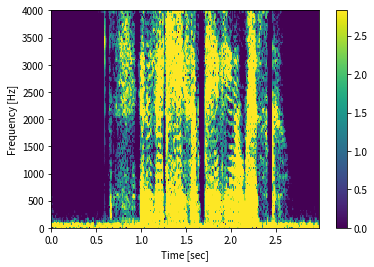

In [30]:
data_number = 42000
pred_show_spe(wav_file_LF[number])

In [31]:
class BCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()

    def forward(self, input, target):
        input = torch.where(torch.isnan(input), torch.zeros_like(input), input)
        input = torch.where(torch.isinf(input), torch.zeros_like(input), input)
        input = torch.where(input>1, torch.ones_like(input), input)  # 1を超える場合には1にする

        target = target.float()

        return self.bce(input, target)

## 実験設定

In [32]:
num_epochs = 3
batch_size = 128
criterion = BCELoss()
mse = nn.MSELoss()
l1 = nn.L1Loss()
#criterion_G = nn.BCELoss() + nn.MSELoss()
lr = 0.0002
lrG = 10**(-5)
lrD = 1.0 * 10**(-5) # 4.0 * 10**(-5)のがいいかも
beta1 = 0.5

# optimizer には Adam を設定
optimizerD = torch.optim.Adam(netD.parameters(), lr=lrD, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, 0.999))

## 学習

Starting Training Loop...
[1/3][0/4346]	Loss_D: 1.3863	Loss_G: 0.6904	D(x): 0.5014	D(G(z)): 0.5014 / 0.5014


<ipython-input-6-ca6ce71e8e39>:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, np.log(magnitude_spectrogram), vmin=0, vmax=amp)


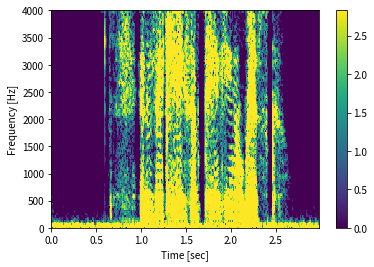

mse: 0.9726787209510803
[1/3][1000/4346]	Loss_D: 1.3792	Loss_G: 0.6988	D(x): 0.5016	D(G(z)): 0.4972 / 0.4975


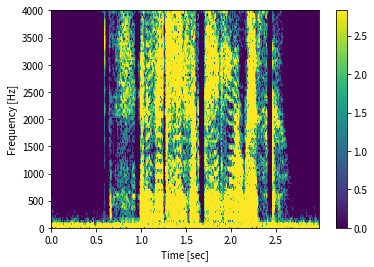

mse: 0.8724842667579651
[1/3][2000/4346]	Loss_D: 1.3729	Loss_G: 0.7273	D(x): 0.5119	D(G(z)): 0.5032 / 0.4838


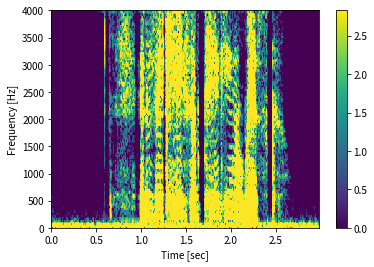

mse: 0.8782780170440674
[1/3][3000/4346]	Loss_D: 1.3759	Loss_G: 0.7281	D(x): 0.5189	D(G(z)): 0.5110 / 0.4836


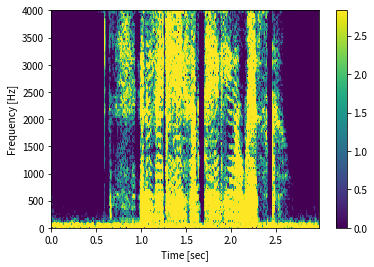

mse: 0.8686071038246155
[1/3][4000/4346]	Loss_D: 1.3682	Loss_G: 0.7600	D(x): 0.5238	D(G(z)): 0.5118 / 0.4684


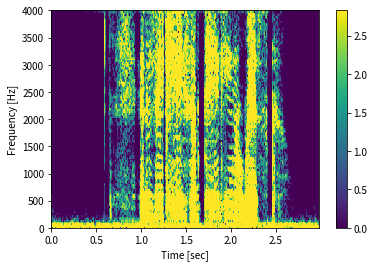

mse: 0.8634844422340393
[2/3][0/4346]	Loss_D: 1.3615	Loss_G: 0.7656	D(x): 0.5082	D(G(z)): 0.4930 / 0.4659


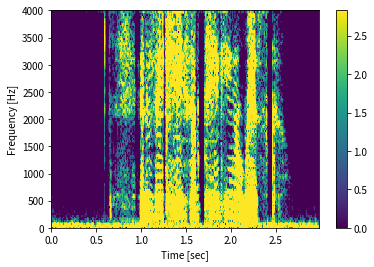

mse: 0.8634636402130127
[2/3][1000/4346]	Loss_D: 1.3518	Loss_G: 0.7283	D(x): 0.5167	D(G(z)): 0.4956 / 0.4840


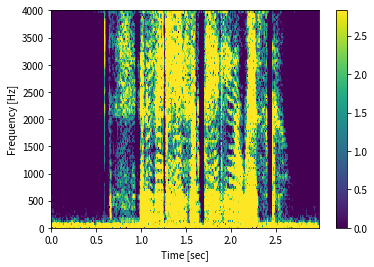

mse: 0.8571855425834656
[2/3][2000/4346]	Loss_D: 1.3546	Loss_G: 0.7342	D(x): 0.5240	D(G(z)): 0.5035 / 0.4816


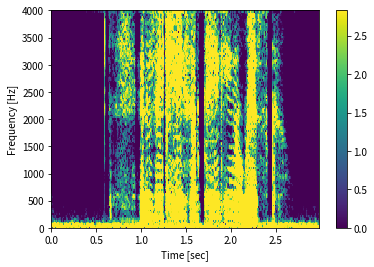

mse: 0.8553337454795837
[2/3][3000/4346]	Loss_D: 1.3590	Loss_G: 0.7687	D(x): 0.5497	D(G(z)): 0.5289 / 0.4654


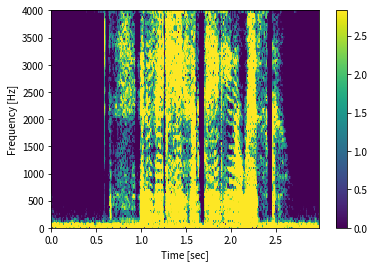

mse: 0.8459787368774414
[2/3][4000/4346]	Loss_D: 1.3462	Loss_G: 0.7678	D(x): 0.5443	D(G(z)): 0.5184 / 0.4653


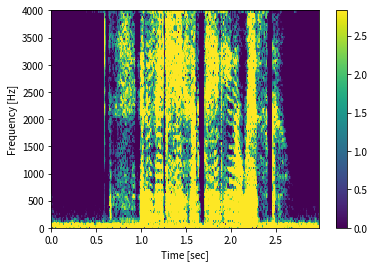

mse: 0.8503643870353699
[3/3][0/4346]	Loss_D: 1.3598	Loss_G: 0.6285	D(x): 0.4790	D(G(z)): 0.4608 / 0.5348


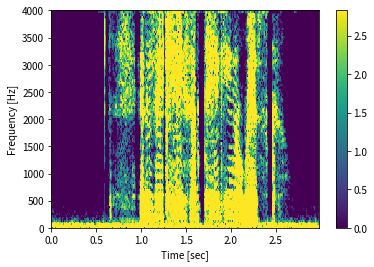

mse: 0.8631213903427124
[3/3][1000/4346]	Loss_D: 1.3395	Loss_G: 0.7950	D(x): 0.5268	D(G(z)): 0.4972 / 0.4535


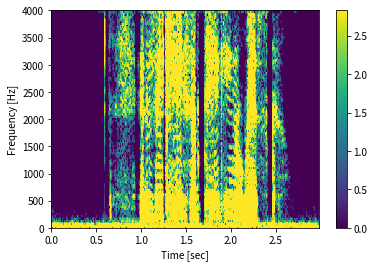

mse: 0.8492783904075623
[3/3][2000/4346]	Loss_D: 1.3327	Loss_G: 0.7149	D(x): 0.5252	D(G(z)): 0.4912 / 0.4914


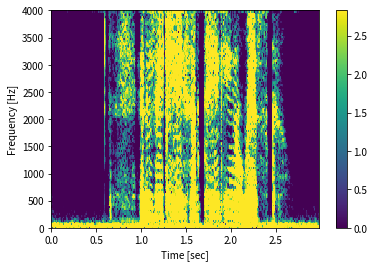

mse: 0.8328388929367065
[3/3][3000/4346]	Loss_D: 1.3519	Loss_G: 0.6067	D(x): 0.4550	D(G(z)): 0.4223 / 0.5481


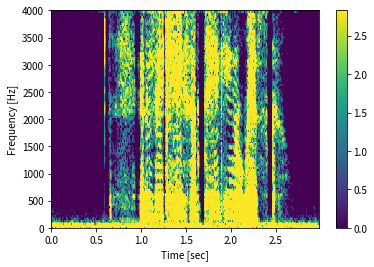

mse: 0.8407207131385803
[3/3][4000/4346]	Loss_D: 1.3553	Loss_G: 0.8377	D(x): 0.5643	D(G(z)): 0.5361 / 0.4353


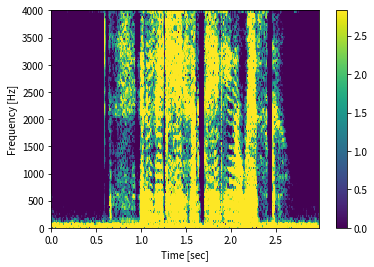

mse: 0.8409682512283325


In [33]:
print("Starting Training Loop...")

# 訓練の進捗状況を把握するためのリスト
G_losses = []
D_losses = []
iters = 0


for epoch in range(num_epochs):
    for i, (X, Y) in enumerate(train_dataloader):
        ############################
        # (1) 識別器Dのネットワーク更新: maximize log(D(x)+ log(1 - D(G(z)) )
        ###########################
        
        # 本物画像のバッチを使った訓練
        netD.zero_grad()
        label = torch.ones((X.shape[0], 1)).to(device)
        #torch.full((b_size,), real_label, dtype=torch.float, device=device) #label = 1 np.ones(batch_size)
        # 本物画像のバッチをDに順伝播させる
        _, output = netD(Y) #0か1を予測
        # 全ての本物画像のバッチの損失を計算する
        errD_real = criterion(output, label) #答え合わせ
        # 逆伝播で勾配を計算する
        errD_real.backward(retain_graph=True)
        D_x = output.mean().item()

        ## 偽物画像のバッチを使った訓練
        
        # Gを使って、偽画像のバッチを生成
        fake = netG(X) #低解像度を入力
        label = torch.zeros((X.shape[0], 1)).to(device)
        # Dを使って、全ての偽画像を分類
        _, output = netD(fake) #0か1
        
        # 全ての偽画像に対するDの損失を計算
        errD_fake = criterion(output, label)
        # 偽画像に対する勾配を計算
        errD_fake.backward(retain_graph=True)
        D_G_z1 = output.mean().item()
        
        
        # 全ての本物画像のバッチの勾配と、全ての偽画像のバッチの勾配を足す
        errD = errD_real + errD_fake
        
        
        # Dのパラメータを更新
        optimizerD.step()

        ############################
        # (2) 生成器Gのネットワークを更新: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label = torch.ones((X.shape[0], 1)).to(device) #Dが間違えたら損失が減るように
        # ちょうど識別器Dを更新したので、偽画像バッチをもう一度識別器Dに順伝播させる
        fake_features, output = netD(fake)
        real_features, _ = netD(y)
        feature_loss = 0
        for n in range(len(fake_features)):
            feature_loss += l1(fake_features[n], real_features[n])
        # この出力に対するGの損失をもう一度計算
        bce_loss = criterion(output, label)
        mse_loss = mse(fake, y)
        errG = 0.1 * bce_loss + 0.2 * mse_loss * (epoch + 1) + (1/len(fake_features)) * feature_loss 
        # Gの勾配を計算
        errG.backward(retain_graph=True)
        D_G_z2 = output.mean().item()
        # Gを更新
        optimizerG.step()
        
        # 訓練のステータスを出力
        if i % 1000 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(train_dataloader),
                     errD.item(), bce_loss.item(), D_x, D_G_z1, D_G_z2))
            pred_show_spe(wav_file_LF[number])
            print('mse: {0}'.format(mse_loss.item()))
        # あとでプロットするために損失を保存
        G_losses.append(bce_loss.item())
        D_losses.append(errD.item())
        
        iters += 1

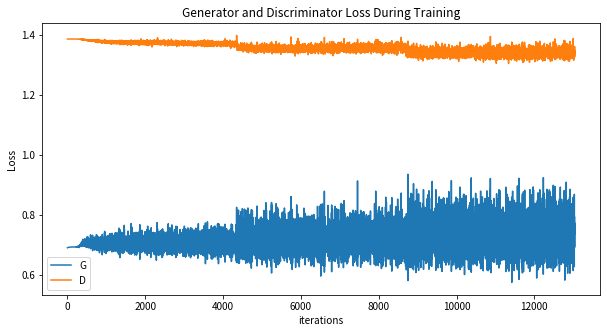

In [34]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 評価

In [35]:
#pred_spec_2d(time_size = 64, data_num = 42600, net = netG, magnitude = LF_magnitude, angle = angle, wav_m = HF_magnitude, wav_name = 'abcd.wav')

In [36]:
#真ん中の予測値をとる.
fs = 8000
netG.eval()
amp = 2 * np.sqrt(2)
pred_spectral=[]
number = 42000
data = LF_magnitude[number]
sp_last = [1e-10]*129
i = 0
nover = 192

pred_sp = []
input_sp = torch.tensor(data)[i:i+time_size]
input_sp = input_sp.unsqueeze(0)
output_sp = netG(input_sp.to(device))
input_sp = input_sp.squeeze().tolist()
output_sp = output_sp.squeeze().tolist()
for j in range(time_size//4):
    sp = output_sp[j]
    pred_sp.append(sp)
while i <= len(data)-time_size:
    input_sp = torch.tensor(data)[i:i+time_size]
    input_sp = input_sp.unsqueeze(0)
    output_sp = netG(input_sp.to(device))
    input_sp = input_sp.squeeze().tolist()
    output_sp = output_sp.squeeze().tolist()
    for j in range(time_size//2):
        sp = output_sp[j+time_size//4]
        pred_sp.append(sp)
    i += time_size//2
#最後
for j in range(time_size//4):
    sp = output_sp[j + 3 * time_size//4]
    pred_sp.append(sp)

input_sp = torch.tensor(data)[-time_size:]
input_sp = input_sp.unsqueeze(0)
output_sp = netG(input_sp.to(device))
input_sp = input_sp.squeeze().tolist()
output_sp = output_sp.squeeze().tolist()
for i in range(len(data)%(time_size//2)):
    sp = output_sp[time_size - len(data)%(time_size//2) + i]
    pred_sp.append(sp)
num_pred = np.array(pred_sp)
magnitude_spectrogram = np.exp(num_pred.T) 
spectral_dnn= get_spectral(angle[number], magnitude_spectrogram)
spectral_dnn = np.where(np.abs(spectral_dnn) >= amp/10, spectral_dnn, 0)
_, wav_xrec = signal.istft(spectral_dnn, fs, nperseg=256, noverlap=nover)
wav_xrec = np.array(wav_xrec, dtype=np.int16) # 戻しておかないとすごい音がする

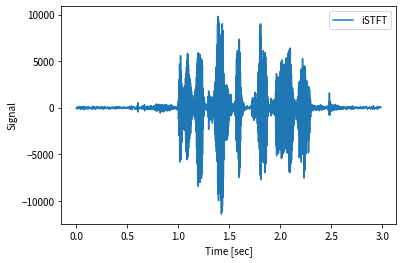

In [37]:
length = len(wav_xrec)
fs = 8000
time = np.arange(length) / float(fs)
plt.plot(time, wav_xrec[:length])
plt.xlabel('Time [sec]')
plt.ylabel('Signal')
plt.legend(['iSTFT'])

plt.show()

### valid_data の音声

In [38]:
from scipy.io.wavfile import write
write('wav_pred/gan_wav_8k_8k.wav', 8000, wav_xrec)
import IPython.display
IPython.display.Audio('wav_pred/gan_wav_8k_8k.wav')

In [39]:
import IPython.display
IPython.display.Audio(wav_file_HF[number])

In [40]:
import IPython.display
IPython.display.Audio(wav_file_LF[number])

### valid_data の振幅スペクトログラム

In [41]:
def stft(read_path):
    nover = 192
    wave_file = wave.open(read_path, "r")

    amp = 2 * np.sqrt(2)
    length = wave_file.getnframes()
    fs = wave_file.getframerate()
    time = np.arange(length) / float(fs)
    x = wave_file.readframes(wave_file.getnframes())
    wav_x = np.frombuffer(x, dtype= "int16")

    f, t, Zxx = signal.stft(wav_x[:length], fs, nperseg=256, noverlap=nover)
    print('フレームレート:{0}'.format(fs))
    plt.pcolormesh(t, f, np.log(np.abs(Zxx)), vmin=0, vmax=amp)
    plt.colorbar()
    plt.title('8000 to 16000')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

フレームレート:8000


<ipython-input-41-3775075894e5>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, np.log(np.abs(Zxx)), vmin=0, vmax=amp)


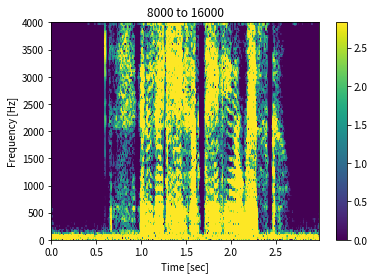

In [42]:
stft("wav_pred/gan_wav_8k_8k.wav")

フレームレート:8000


<ipython-input-41-3775075894e5>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, np.log(np.abs(Zxx)), vmin=0, vmax=amp)


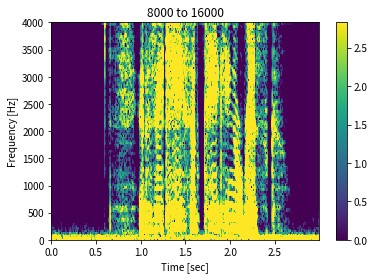

In [43]:
stft(wav_file_HF[number])

フレームレート:8000


<ipython-input-41-3775075894e5>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, np.log(np.abs(Zxx)), vmin=0, vmax=amp)


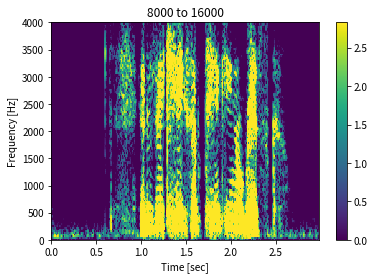

In [44]:
stft(wav_file_LF[number])

## モデルの出力を書き出す

In [49]:
def pred_spec_2d_write(time_size, data_num, net, magnitude, angle, wav_m, wav_name):
    #出力の真ん中部分の採用
    net.eval()
    pred_spectral=[]
    pred_sp = []
    amp = 2 * np.sqrt(2)
    #time_size = 32
    sp_size = 129
    lengths = min(len(wav_m[data_num]), len(magnitude[data_num]))
    #print(lengths)
    data = magnitude[data_num][:lengths]
    nover = 192
    sp_0 = [1e-10] * sp_size
    
    i = 0
    input_sp = torch.tensor(data)[i:i+time_size]
    input_sp = input_sp.unsqueeze(0)
    output_sp = net(input_sp.to(device))
    output_sp = output_sp.squeeze().tolist()
    #最初のdata:32*129のうち前半 1/4部分
    for j in range(time_size//4):
        if j == 0:
            pred_sp.append(sp_0)
        else:
            sp = output_sp[j]
            pred_sp.append(sp)

    #中間のdeta:32*129のうち真ん中　2/4部分
    while i <= len(data)-time_size:
        input_sp = torch.tensor(data)[i:i+time_size]
        input_sp = input_sp.unsqueeze(0)
        output_sp = net(input_sp.to(device))
        output_sp = output_sp.squeeze().tolist()
        for j in range(time_size//2):
            sp = output_sp[j + time_size//4]
            pred_sp.append(sp)
        i += time_size//2

    #最後のdata:32*129のうち後半 1/4部分
    for j in range(time_size//4):
        sp = output_sp[j + 3 * time_size//4]
        pred_sp.append(sp)

    input_sp = torch.tensor(data)[-time_size:]
    input_sp = input_sp.unsqueeze(0)
    output_sp = net(input_sp.to(device))
    output_sp = output_sp.squeeze().tolist()
    for i in range(len(data)%(time_size//2)):
        sp = output_sp[time_size - len(data)%(time_size//2) + i]
        pred_sp.append(sp)

    num_pred = np.array(pred_sp)
    magnitude_spectrogram = np.exp(num_pred.T) 

    spectral_cnn_2d = get_spectral(angle[data_num][:, :lengths], magnitude_spectrogram)
    spectral_cnn_2d = np.where(np.abs(spectral_cnn_2d) >= amp/10, spectral_cnn_2d, 0)
    _, wav_xrec_2d = signal.istft(spectral_cnn_2d, 8000, nperseg=256, noverlap=nover)
    wav_xrec_2d = np.array(wav_xrec_2d, dtype=np.int16) # 戻しておかないとすごい音がする
    
    write(wav_name, 8000, wav_xrec_2d)

In [50]:
# wav_file = sorted(glob.glob('wav_down_8000/*.wav'))
# for n, data in enumerate(wav_file):
#         data = data.replace('wav_down_8000/','')
#         pred_spec_2d_write(time_size = 64, data_num = n, net = netG, magnitude = LF_magnitude, angle = angle, wav_m = HF_magnitude, wav_name = 'best_celp_wav_to_8000/' + data)
#         if n%5000 == 0:
#             print(n)

0
5000
10000
15000
20000
25000
30000
35000
40000


## 客観的評価指標(LSD : Log Spectrogram Distance) の測定

In [47]:
def pred_spec_2d(time_size, data_num, net, magnitude, angle, wav_m, wav_name):
    #出力の真ん中部分の採用
    net.eval()
    pred_spectral=[]
    pred_sp = []
    amp = 2 * np.sqrt(2)
    #time_size = 32
    sp_size = 129
    lengths = min(len(wav_m[data_num]), len(magnitude[data_num]))
    #print(lengths)
    data = magnitude[data_num][:lengths]
    nover = 192
    sp_0 = [1e-10] * sp_size
    
    i = 0
    input_sp = torch.tensor(data)[i:i+time_size]
    input_sp = input_sp.unsqueeze(0)
    output_sp = net(input_sp.to(device))
    output_sp = output_sp.squeeze().tolist()
    #最初のdata:32*129のうち前半 1/4部分
    for j in range(time_size//4):
        if j == 0:
            pred_sp.append(sp_0)
        else:
            sp = output_sp[j]
            pred_sp.append(sp)

    #中間のdeta:32*129のうち真ん中　2/4部分
    while i <= len(data)-time_size:
        input_sp = torch.tensor(data)[i:i+time_size]
        input_sp = input_sp.unsqueeze(0)
        output_sp = net(input_sp.to(device))
        output_sp = output_sp.squeeze().tolist()
        for j in range(time_size//2):
            sp = output_sp[j + time_size//4]
            pred_sp.append(sp)
        i += time_size//2

    #最後のdata:32*129のうち後半 1/4部分
    for j in range(time_size//4):
        sp = output_sp[j + 3 * time_size//4]
        pred_sp.append(sp)

    input_sp = torch.tensor(data)[-time_size:]
    input_sp = input_sp.unsqueeze(0)
    output_sp = net(input_sp.to(device))
    output_sp = output_sp.squeeze().tolist()
    for i in range(len(data)%(time_size//2)):
        sp = output_sp[time_size - len(data)%(time_size//2) + i]
        pred_sp.append(sp)

    num_pred = np.array(pred_sp)
    magnitude_spectrogram = np.exp(num_pred.T) 
    
# 「スペクトログラムの高周波帯と低周波帯を分割して測定する場合」

#     input_up = magnitude[data_num][:lengths, sp_size//2:]
#     input_down = magnitude[data_num][:lengths, :sp_size//2]
    
#     lsd_in_label_up = LSD(input_up, wav_m[data_num][:lengths, sp_size//2:])
#     lsd_in_label_down = LSD(input_down, wav_m[data_num][:lengths, :sp_size//2])
#     lsd_out_label_up = LSD(num_pred[:lengths, sp_size//2:], wav_m[data_num][:lengths, sp_size//2:])
#     lsd_out_label_down = LSD(num_pred[:lengths, :sp_size//2], wav_m[data_num][:lengths, :sp_size//2])

# 「分割せずに全体で測定する場合」
    lsd_pre = LSD(num_pred[:lengths], wav_m[data_num][:lengths])
    
    spectral_cnn_2d = get_spectral(angle[data_num][:, :lengths], magnitude_spectrogram)
    spectral_cnn_2d = np.where(np.abs(spectral_cnn_2d) >= amp/10, spectral_cnn_2d, 0)
    _, wav_xrec_2d = signal.istft(spectral_cnn_2d, 8000, nperseg=256, noverlap=nover)
    wav_xrec_2d = np.array(wav_xrec_2d, dtype=np.int16) # 戻しておかないとすごい音がする
    
    _, _, Zxx = signal.stft(wav_xrec_2d, 8000, nperseg = 256, noverlap = nover)
    
# 「波形に戻した後, 再度スペクトログラムを計算し LSD を測定する場合」
    lsd = LSD(np.log(np.abs(Zxx.T)[:length] + 10**(-10)), wav_m[data_num][:lengths])

    #print('LSD_in_label_up : {0}, LSD_out_label_up : {1}'.format(lsd_in_label_up, lsd_out_label_up))
    #print('LSD_in_label_down : {0}, LSD_out_label_down : {1}'.format(lsd_in_label_down, lsd_out_label_down))
    
    #write(wav_name, 8000, wav_xrec_2d)
    #return IPython.display.Audio(wav_name)
    return lsd_pre, lsd

In [48]:
#noverlap = 1
lsd_pre = 0
lsd = 0
i = 0
for n in range(40698, len(LF_magnitude)):
    i += 1
    if n in u_64:
        continue
    else:
        l_pre, l = pred_spec_2d(time_size = 64, data_num = n, net = netG, magnitude = LF_magnitude, angle = angle, wav_m = HF_magnitude, wav_name = 'a.wav')
        lsd_pre += l_pre
        lsd += l
        if i%500 == 0:
            print(lsd_pre/i, lsd/i)
print('LSD_pre : {0}, LSD : {1}'.format(lsd_pre/i, lsd/i))

0.8804886005677499 1.1324875971632442
0.8867575463288273 1.1354520133096184
0.8874487087650303 1.1325671387082001
0.8952735234971607 1.1490468752845382
0.9023900347499412 1.154326987670423
0.9014923174070512 1.1494661910057546
0.9035158497272482 1.1603742446715593
LSD_pre : 0.9036956405170373, LSD : 1.163627649734574
